# 剪刀石头布识别结果展示

### 导入必须的外部库

In [2]:
# coding:utf-8
import os
import warnings
from sklearn import model_selection
import cv2 as cv
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import svm
from skimage import feature as sf
warnings.filterwarnings("ignore")

### 定义工具函数 包括阈值分割和特征提取函数等

In [3]:
def thre(src):
    '''二值图像获取'''
    # OTSU阈值分割
    t, img = cv.threshold(src, 20, 255, cv.THRESH_OTSU)
    # 对二值图像进行去噪操作
    # 开运算
    kernel = np.ones((3, 3), np.uint8)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=3)
    # 中值滤波
    img = cv.medianBlur(img, 7)
    return img


def circle_similar(src):
    '''似圆度'''
    contour, hierarchy = cv.findContours(
        src, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    length = 0
    area = 0
    # 寻找最大图形的周长和面积
    for i in range(len(contour)):
        c = contour[i].astype(np.float32)
        length = max(length, cv.arcLength(c, True))
        area = max(area, cv.contourArea(c))
    return length**2 / area


def Area(src):
    '''面积'''
    contour, hierarchy = cv.findContours(
        src, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    area = 0
    # 寻找最大图形的面积
    for i in range(len(contour)):
        c = contour[i].astype(np.float32)
        area = max(area, cv.contourArea(c))
    return area


def hr(src):
    '''角点数量'''
    # Harris角点检测
    points = cv.cornerHarris(src, 3, 7, 0.05)
    # 统计非0点数量
    ret = np.count_nonzero(points)
    return ret


def eccentricity(src):
    '''离心率'''
    contours, hierarchy = cv.findContours(
        src, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    nmax = 0
    # 寻找最大轮廓
    for i in range(len(contours)):
        if len(contours[i]) > nmax:
            nmax = i
    # 计算外接椭圆
    ell = cv.fitEllipse(contours[nmax])
    a, b = max(ell[1])/2, min(ell[1])/2
    c = np.sqrt(a**2-b**2)
    return c/a


def hog(src):
    '''HOG'''
    # 降低图形分辨率以减小特征维度
    img = cv.resize(src, (150, 150))
    hog_array = sf.hog(img, orientations=8, pixels_per_cell=(
        15, 15), cells_per_block=(10, 10))
    return hog_array


def get_features(src):
    '''获取特征向量'''
    # 转换颜色空间
    img = cv.cvtColor(src, cv.COLOR_RGB2HSV)
    h_channel, s_channel, v_channel = cv.split(img)
    # 对h通道进行阈值分割
    img = thre(h_channel)
    # 获取特征
    a = Area(img)
    s = circle_similar(img)
    e = eccentricity(img)
    n = hr(img)
    h = hog(img)
    return a, s, e, n, h


def get_label(idx):
    '''根据索引获取标签内容'''
    labels = ["paper", "scissors", "rock"]
    return labels[int(idx)]


def get_idx(label):
    '''根据标签获取对应索引'''
    labels = {"paper": 0, "scissors": 1, "rock": 2}
    return labels[label]

### 训练SVM分类器

由于生成特征向量部分用时较长，因此不在此处展示

In [4]:
data = pd.read_csv("data/features.csv", encoding="gbk")
# 将类别转换为索引
data["类别"][data["类别"] == "paper"] = 0
data["类别"][data["类别"] == "scissors"] = 1
data["类别"][data["类别"] == "rock"] = 2
x_data = data.iloc[:, :-1].to_numpy(np.float32)
y_data = data["类别"].to_numpy(dtype=np.float32)
# 分割训练集和测试集
train_data, test_data, train_label, test_label = model_selection.train_test_split(
    x_data, y_data, random_state=1, test_size=0.25, train_size=0.75)
# 定义SVM分类器
svmClassfication = svm.SVC(
    C=100, kernel="rbf", gamma=1e-5, decision_function_shape="ovr", max_iter=50000)
# 训练SVM分类器
svmClassfication = svmClassfication.fit(train_data, train_label)
print("训练集:{: >8.4f}%".format(
    svmClassfication.score(train_data, train_label)*100))
print("验证集:{: >8.4f}%".format(
    svmClassfication.score(test_data, test_label)*100))


训练集: 98.2011%
验证集: 95.3968%


### 部分图像特征向量展示

以自采数据为例，展示形状特征和HOG特征图像

面积:23642.5
似圆度:42.163450103468115
离心率:0.8277153738377189
角点数量:8547


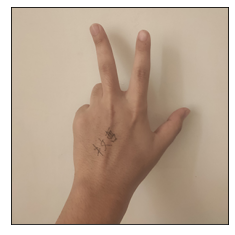

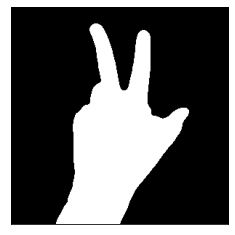

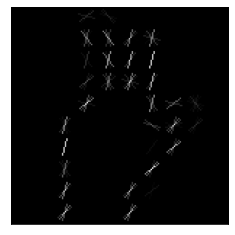

In [5]:
file_path = "data/test"
files = os.listdir(file_path)
filename = "data/test/nwz_scissors_1.jpg"
# filename = "data/test/nwz_paper_2.jpg"
# filename = "data/test/test_scissors_9.png"
src = cv.imread(filename)
img = cv.cvtColor(src, cv.COLOR_RGB2HSV)
h, s, v = cv.split(img)
img = thre(h)

a = Area(img)
s = circle_similar(img)
n = hr(img)
e = eccentricity(img)
normalised_blocks, hog_image = sf.hog(cv.resize(img, (150, 150)), orientations=8, pixels_per_cell=(
    15, 15), cells_per_block=(10, 10), block_norm='L2-Hys', visualize=True)
print("面积:{}\n似圆度:{}\n离心率:{}\n角点数量:{}".format(a,s,e,n))


plt.xticks([])
plt.yticks([])
plt.imshow(cv.cvtColor(src,cv.COLOR_BGR2RGB))

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(img, cmap="gray")

plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(hog_image,cmap="gray")

### 测试集结果展示

In [6]:
cnt = 0
for i in range(len(files)):
    name = files[i]
    file_name = file_path+"/"+name
    # 分类文件名中的标签信息
    label = name.split("_")[1]
    # 转换为索引以便于比较
    label_idx = get_idx(label)
    # 读取图像并提取特征
    src = cv.imread(file_name)
    a, s, e, n, h = get_features(src)
    x = np.array([a, s, e, n])
    x = np.hstack([x, h]).reshape(1, -1)
    # 获取预测值(标签索引)
    y = svmClassfication.predict(x)
    # 判断预测的准确性并计算准确率
    print("样本{}\t\t标签:{}\t\t分类:{}".format(name, label, get_label(y.item())))
    if label_idx == y.item():
        cnt += 1
print(f"\n分类准确率:{cnt/len(files)*100}%")


样本nwz_paper_1.jpg		标签:paper		分类:paper
样本nwz_paper_2.jpg		标签:paper		分类:paper
样本nwz_paper_3.jpg		标签:paper		分类:paper
样本nwz_rock_1.jpg		标签:rock		分类:rock
样本nwz_rock_2.jpg		标签:rock		分类:rock
样本nwz_rock_3.jpg		标签:rock		分类:rock
样本nwz_scissors_1.jpg		标签:scissors		分类:scissors
样本nwz_scissors_2.jpg		标签:scissors		分类:scissors
样本nwz_scissors_3.jpg		标签:scissors		分类:scissors
样本test_paper_6.png		标签:paper		分类:paper
样本test_paper_7.png		标签:paper		分类:paper
样本test_rock_6.png		标签:rock		分类:rock
样本test_rock_8.png		标签:rock		分类:rock
样本test_scissors_6.png		标签:scissors		分类:scissors
样本test_scissors_9.png		标签:scissors		分类:scissors

分类准确率:100.0%
